__Import libraries__

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [6]:
df=pd.read_csv('well_without_outlier.csv')

In [4]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 16.1 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)


In [7]:
df=df.drop('Flow Out %',axis=1)

In [8]:
#Statistical description of the selected features for the target variable ROP
df.describe()

,ROP(1 m),Depth(m),weight on bit (kg),Rotary Speed (rpm),Pump Press (KPa),Temp In(degC),Flow In(liters/min)
count,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000
mean,12.569735,1170.125075,10492.418940,54.855718,8737.605204,47.953857,2710.542394
std,20.194831,654.397245,4130.250795,25.296998,3378.177407,6.626395,511.248043
min,0.000000,25.960000,0.000000,0.000000,137.490000,29.440000,0.000000
25%,3.470000,601.940000,8308.390000,38.120000,4593.170000,42.720000,2347.940000
50%,5.470000,1176.130000,10807.260000,50.380000,9877.500000,47.340000,2650.580000
75%,13.460000,1736.100000,13460.320000,75.950000,11510.100000,52.700000,3120.960000
max,274.750000,2296.940000,21337.870000,178.860000,15171.960000,63.510000,5864.130000


In [9]:
X=df.drop('ROP(1 m)',axis=1)
y=df['ROP(1 m)']
print('the Shape of x is :',X.shape)
print('the Shape of y is :',y.shape)

the Shape of x is : (7293, 6)
the Shape of y is : (7293,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [11]:
#convert the normalized features into numpy array 
scaler=MinMaxScaler().fit(X_train)
scaled_X_train=np.array(scaler.transform(X_train))
scaled_X_test=np.array(scaler.transform(X_test))

In [12]:
#convert the target variable into numpy array 
ny_train=np.array(y_train)
ny_test=np.array(y_test)

In [13]:
#intialize a sequential model to be tuned later
def ANN_model(nl=0,nn=6):
    model = Sequential()
    model.add(Dense(6,input_dim=6,activation="relu"))
    for i in range(nl):
        model.add(Dense(nn, activation='relu'))  
    
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam',metrics=['mse'] )
    return model  
       

In [14]:
ANN_model().summary()

2023-02-06 10:31:48.888282: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-06 10:31:48.888838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 batch_normalization (BatchN  (None, 6)                24        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 73
Trainable params: 61
Non-trainable params: 12
_________________________________________________________________


In [15]:
#create a KerasRegressor based on this ANN_model()
Ann_reg=KerasRegressor(build_fn=ANN_model,epochs=200, batch_size=16)

/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/3119779875.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Ann_reg=KerasRegressor(build_fn=ANN_model,epochs=200, batch_size=16)


In [16]:
#choosing the number of layers and number of neurons as hyperparameters 
param={'nl':[0,1,2],'nn':[2,3,6,12,24]}
grid_cv = GridSearchCV(Ann_reg, param_grid=param, cv=5,verbose=2,scoring='neg_mean_absolute_error')

In [19]:
grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
#Note that GridSearchCV uses K-fold cross-validation, so it does not use validation_split, These are just used for early stopping


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Epoch 1/200


2023-02-06 10:33:17.425891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:17.549073: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.549098: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.553903: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.570504: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.585368: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:17.793762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:17.911918: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.911943: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.916981: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.934742: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:17.950105: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:18.155228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:18.291700: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.291726: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.296859: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.314193: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.330872: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:18.538742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:18.665987: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.666010: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.671266: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.688691: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:18.704196: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:18.908577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:19.028028: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.028051: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.034626: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.056146: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.071591: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:19.672470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:19.806290: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.806314: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.810960: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.828000: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:19.843288: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=3; total time=   0.8s
Epoch 1/200


2023-02-06 10:33:20.053734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:20.179137: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.179161: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.184303: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.209008: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.232951: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:20.434330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:20.553560: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.553585: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.558634: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.575885: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.592096: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=3; total time=   0.4s
Epoch 1/200
[CV] END .........................................nl=0, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:20.796580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:20.914462: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.914487: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.919512: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.935535: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:20.950701: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:21.528623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:21.681272: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:21.681297: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:21.687313: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:21.703661: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:21.717007: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:21.922360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:22.045447: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.045472: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.049798: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.067230: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.084818: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:22.288445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:22.407801: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.407825: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.412896: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.431070: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.447430: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:22.655492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:22.773702: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.773729: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.778513: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.795602: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:22.810945: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:23.022759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:23.164636: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.164661: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.172018: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.198076: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.220907: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=0, nn=6; total time=   0.4s
Epoch 1/200
[CV] END ........................................nl=0, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:23.427763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:23.544273: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.544299: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.549399: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.565992: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.579622: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:23.994358: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:23.994378: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:24.202275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:24.324227: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:24.324252: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:24.332700: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:25.033525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:25.172814: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.172837: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.179464: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.203131: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.223882: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=12; total time=   0.8s
Epoch 1/200
[CV] END ........................................nl=0, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:25.425028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:25.544940: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.544966: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.549982: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.566306: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:25.580967: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:26.144470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:26.289022: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.289047: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.293314: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.311431: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.327773: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:26.533687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:26.695068: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.695092: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.701471: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.723723: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=0, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:26.744856: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.744877: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:26.949121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:27.075957: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.075982: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.083222: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:27.346229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:27.490697: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.490721: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.497324: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.520091: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.540688: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=0, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:27.774251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:27.935200: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.935227: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.942253: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.968072: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END .........................................nl=1, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:27.995066: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.995088: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.998106: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:27.998122: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.233178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:28.396784: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:28.454083: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.454108: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.457274: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.457293: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.692978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:28.867598: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:28.908668: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.936445: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.936467: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.940309: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:28.940329: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.174744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:29.378231: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.407682: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.407704: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.410856: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.410871: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.644220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:29.855886: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.884810: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.884830: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.888288: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:29.888309: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:30.560333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=3; total time=   0.9s
Epoch 1/200


2023-02-06 10:33:30.783160: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:30.826001: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:30.826025: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:30.829031: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:30.829048: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.057386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:31.265482: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.265501: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.268353: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.268368: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.499099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:31.657082: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:31.713291: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.713312: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.716305: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.716320: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:31.951175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:32.110453: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:32.170180: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.170201: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.173163: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.173176: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.404011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:32.565165: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:32.628176: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.628197: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.631243: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.631258: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:32.867210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:33.019665: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:33.076128: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.076154: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.079079: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.079094: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.315465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:33.497756: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=1, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:33.544799: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.574752: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.574773: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.578236: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.578258: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:33.827859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:34.039598: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.068778: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.068799: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.072452: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.072467: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.334288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:34.550811: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.579022: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.579043: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.582601: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.582615: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:34.817682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=1, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:35.019201: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.019221: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.022535: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.022550: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.257260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:35.433289: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=1, nn=12; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:35.468478: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.498921: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.498944: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.502310: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.502325: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:35.738968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END ........................................nl=1, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:36.613308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:36.779638: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.779664: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.794964: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=1, nn=12; total time=   1.0s
Epoch 1/200


2023-02-06 10:33:36.828180: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.868647: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.868673: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.871856: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:36.871874: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.109177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END ........................................nl=1, nn=12; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:37.325263: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.325282: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.328242: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.328256: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=1, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:37.559541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:37.664982: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.665006: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.667837: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.677727: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:37.688211: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=1, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:38.356298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[CV] END ........................................nl=1, nn=24; total time=   0.6s
Epoch 1/200


2023-02-06 10:33:38.619994: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:38.620018: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:38.627494: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:38.653988: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:38.680678: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:38.680704: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END ........................................nl=1, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:39.141323: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:39.168712: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:39.168734: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:39.171992: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:39.172006: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:39.418477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END ........................................nl=1, nn=24; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:39.837167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:40.005847: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.005872: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.022922: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=1, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:40.049079: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.075318: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.075339: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.078456: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.078470: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.344489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_regist

[CV] END .........................................nl=2, nn=2; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:40.771345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:40.952477: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.952506: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:40.960361: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END .........................................nl=2, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:40.991163: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:41.019041: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:41.019063: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:41.025683: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:41.025703: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:41.034743: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:42.187288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:42.327992: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.328016: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.334359: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.345106: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.355845: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=2, nn=2; total time=   0.9s
Epoch 1/200


2023-02-06 10:33:42.617421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:42.788295: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.788320: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.795690: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END .........................................nl=2, nn=2; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:42.823886: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.850631: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.850653: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.856826: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.856841: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:42.860086: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:43.323808: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.351238: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.351261: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.357797: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.357818: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.361172: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:43.830546: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.830563: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.837733: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.837747: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.840942: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:43.840956: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:44.307349: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:44.333944: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:44.333964: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:44.339976: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:44.339991: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:44.342985: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=3; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:45.063828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:45.187586: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.187610: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.191032: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.202297: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.213919: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=2, nn=3; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:45.477498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:45.602666: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.602690: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.606309: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.621459: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:45.638379: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END .........................................nl=2, nn=6; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:45.904280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:46.085665: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.085691: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.093518: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END .........................................nl=2, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:46.121077: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.148968: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.148990: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.156803: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.156826: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.160192: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:46.631899: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.631921: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.636228: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.636245: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.638432: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:46.638447: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=6; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:47.109993: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:47.136469: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:47.163678: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:47.163700: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:47.170410: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:47.170427: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END .........................................nl=2, nn=6; total time=   0.9s
Epoch 1/200


2023-02-06 10:33:48.339427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:48.518987: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.519012: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.526785: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=2, nn=12; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:48.553124: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.595701: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.595722: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.604654: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.604669: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:48.607853: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END ........................................nl=2, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:49.302786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:49.439753: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.439777: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.444370: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.459743: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.475994: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=2, nn=12; total time=   0.4s
Epoch 1/200


2023-02-06 10:33:49.741321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:49.901388: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.901411: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.906308: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.923130: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.940275: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=2, nn=12; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:49.944340: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.944354: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.946412: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:49.946426: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:50.205483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:50.350800: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=2, nn=12; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:50.657841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:50.801617: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:50.801643: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:50.806840: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:50.825434: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:50.844122: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

[CV] END ........................................nl=2, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:51.110101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:33:51.265308: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.265333: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.273034: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.300390: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770


[CV] END ........................................nl=2, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:51.328543: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.328564: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.335101: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.335118: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.338423: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.338437: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END ........................................nl=2, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:51.818414: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.851031: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.851054: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.857924: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.857947: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:51.861397: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END ........................................nl=2, nn=24; total time=   0.5s
Epoch 1/200


2023-02-06 10:33:52.355650: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:52.355674: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:52.362226: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:52.362245: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:52.365622: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:52.365639: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

[CV] END ........................................nl=2, nn=24; total time=   0.9s


2023-02-06 10:33:53.261536: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:53.261559: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:53.268281: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:53.268299: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:53.271635: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:33:53.271650: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed a

ValueError: 
All the 75 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1085, in __call__
      if self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_98047]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_99149]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_100251]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_101353]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_102455]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_103557]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_104659]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_105761]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_106863]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_107965]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_109067]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_110169]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_111271]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_112373]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_113475]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_114577]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_115679]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_116781]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_117883]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_118985]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_120087]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_121189]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_122291]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_123393]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_124495]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_125786]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_127077]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_128368]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_129659]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_130950]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_132241]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_133532]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_134823]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_136114]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_137405]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_138696]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_139987]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_141278]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_142569]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_143860]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_145151]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_146442]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_147733]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_149024]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_150315]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_151606]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_152897]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_154188]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_155479]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_6' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_6'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_6}}]] [Op:__inference_train_function_156770]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_158250]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_159730]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_161210]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_162690]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_164170]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_165650]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_167130]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_168610]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_170090]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_171570]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_173050]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_174530]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_176010]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_177490]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_178970]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_180450]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_181930]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_183410]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_184890]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_186370]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_187850]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_189330]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_190810]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_192290]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/1622849921.py", line 1, in <cell line: 1>
      grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 874, in fit
      self._run_search(evaluate_candidates)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1388, in _run_search
      evaluate_candidates(ParameterGrid(self.param_grid))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 821, in evaluate_candidates
      out = parallel(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 63, in __call__
      return super().__call__(iterable_with_config)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 1088, in __call__
      while self.dispatch_one_batch(iterator):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
      self._dispatch(tasks)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
      job = self._backend.apply_async(batch, callback=cb)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
      result = ImmediateResult(func)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
      self.results = batch()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/utils/parallel.py", line 123, in __call__
      return self.function(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_193770]


In [24]:
#the best hyperparameter values for ANN_model

grid_cv.best_params_

TypeError: 'int' object is not callable

In [26]:
# best_ann=grid_cv.best_estimator_
best_ann=grid_cv.estimator

In [27]:
#Now try to fit the model by using callbacks , monitor the validation loss and save only the best model
best_ann.fit(scaled_X_train, ny_train,validation_split=0.2,verbose=2,callbacks=[EarlyStopping(patience=10),ModelCheckpoint('best_model.hdf5',save_best_only=True)])

Epoch 1/200


2023-02-06 10:40:26.895816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-06 10:40:27.068874: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:40:27.068900: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:40:27.077162: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:40:27.104406: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOUND: could not find registered platform with id: 0x11ee3e770
2023-02-06 10:40:27.138746: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:418 : NOT_FOU

NotFoundError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 724, in start
      self.io_loop.start()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
      await result
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/73/r__fy3qd5fqf46_jrr1pmhm80000gn/T/ipykernel_55455/3593022899.py", line 2, in <cell line: 2>
      best_ann.fit(scaled_X_train, ny_train,validation_split=0.2,verbose=2,callbacks=[EarlyStopping(patience=10),ModelCheckpoint('best_model.hdf5',save_best_only=True)])
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 175, in fit
      history = self.model.fit(x, y, **fit_args)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
could not find registered platform with id: 0x11ee3e770
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_194872]

In [14]:
#loading the model from checkpoint
best_ann=load_model('best_model.hdf5')

In [15]:
#the best ANN architechture
best_ann.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_246 (Dense)            (None, 12)                84        
_________________________________________________________________
dense_247 (Dense)            (None, 12)                156       
_________________________________________________________________
batch_normalization_82 (Batc (None, 12)                48        
_________________________________________________________________
dense_248 (Dense)            (None, 1)                 13        
Total params: 343
Trainable params: 319
Non-trainable params: 24
_________________________________________________________________


In [29]:
predictions=best_ann.predict(scaled_X_test)

In [30]:
#evaluate the model metrics
print('mean absolut error', mean_absolute_error(ny_test,predictions)) 
print('R2 score',r2_score(ny_test,predictions)) 
print('root mean squared error',np.sqrt(mean_squared_error(ny_test,predictions)))

mean absolut error 3.981443954264162
R2 score 0.7342305400432674
root mean squared error 10.733163812094562


Text(0, 0.5, 'Predicted')

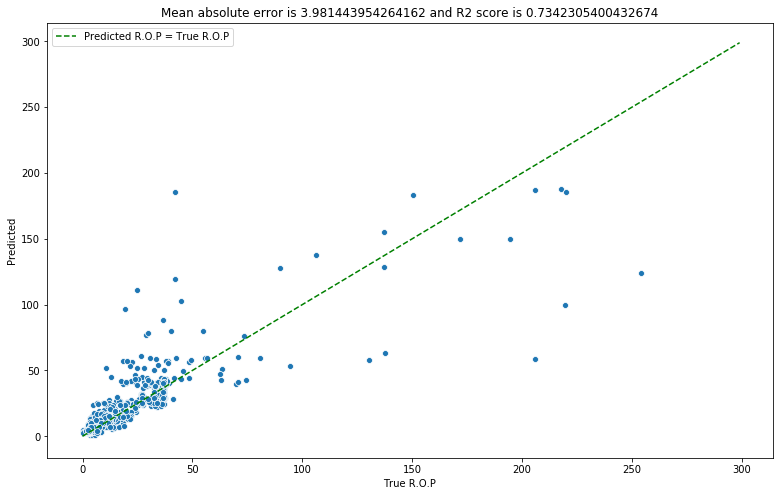

In [54]:
plt.figure(figsize=(13,8))
plt.title('Mean absolute error is {} and R2 score is {}'.format(mean_absolute_error(y_test,predictions),r2_score(y_test,predictions)))
plt.plot(np.arange(0,300,1),np.arange(0,300,1),color='green', linestyle='dashed',label='Predicted R.O.P = True R.O.P')
sns.scatterplot(x=ny_test,y=predictions[:,0])
plt.xlabel('True R.O.P')
plt.ylabel('Predicted')

In [53]:
predictions[:,0]

array([14.577316 ,  6.4878964,  6.9583817, ..., 38.020683 , 25.305702 ,
        4.301601 ], dtype=float32)

__Examining the best model__

In [79]:
final_model=Sequential()
final_model.add(Dense(6,input_dim=6,activation="relu"))
final_model.add(Dense(12,activation="relu"))
final_model.add(Dense(12,activation="relu"))
final_model.add(BatchNormalization())
final_model.add(Dense(1))
final_model.compile(optimizer="adam", loss="mse", metrics = ['mae'])

In [80]:
final_model.fit(scaled_X_train, ny_train, batch_size=16 ,epochs=200,validation_split=0.2,verbose=2)

Train on 4084 samples, validate on 1021 samples
Epoch 1/200
4084/4084 - 1s - loss: 451.1289 - mae: 11.4200 - val_loss: 518.6111 - val_mae: 11.5853
Epoch 2/200
4084/4084 - 0s - loss: 311.3053 - mae: 8.6796 - val_loss: 295.1972 - val_mae: 7.7628
Epoch 3/200
4084/4084 - 0s - loss: 240.0944 - mae: 6.3322 - val_loss: 192.9825 - val_mae: 4.9039
Epoch 4/200
4084/4084 - 0s - loss: 211.4279 - mae: 5.3326 - val_loss: 177.7657 - val_mae: 5.1478
Epoch 5/200
4084/4084 - 0s - loss: 187.5106 - mae: 5.2680 - val_loss: 161.1128 - val_mae: 4.9752
Epoch 6/200
4084/4084 - 0s - loss: 184.0275 - mae: 5.5751 - val_loss: 166.6875 - val_mae: 5.1826
Epoch 7/200
4084/4084 - 0s - loss: 181.6865 - mae: 5.4870 - val_loss: 143.1336 - val_mae: 4.6184
Epoch 8/200
4084/4084 - 0s - loss: 177.6832 - mae: 5.6224 - val_loss: 136.5755 - val_mae: 5.0947
Epoch 9/200
4084/4084 - 1s - loss: 178.2930 - mae: 5.5083 - val_loss: 128.3143 - val_mae: 4.4879
Epoch 10/200
4084/4084 - 0s - loss: 173.5647 - mae: 5.7036 - val_loss: 142.73

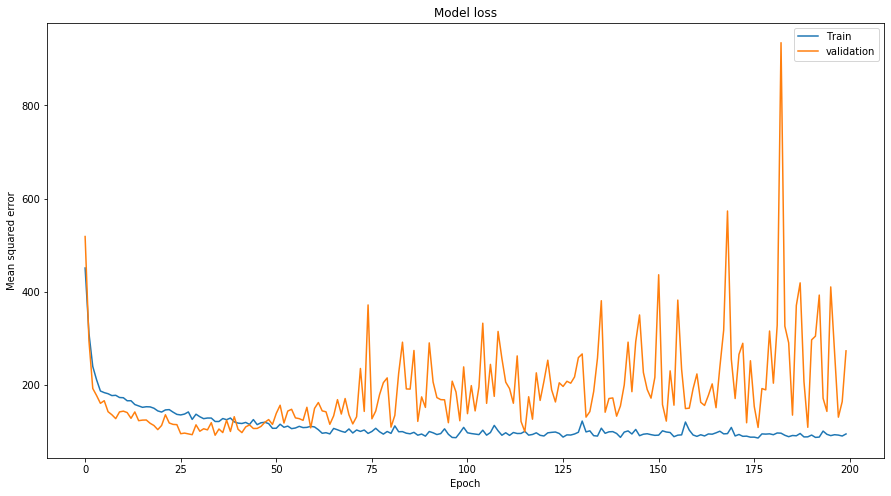

In [82]:
#by ploting the learning curves of the neural netwrok we can see that 100 epochs are enough train it 
plt.figure(figsize=(15,8))
# Use the history metrics
plt.plot(final_model.history.history['loss'])
plt.plot(final_model.history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(['Train', 'validation'])
plt.show()

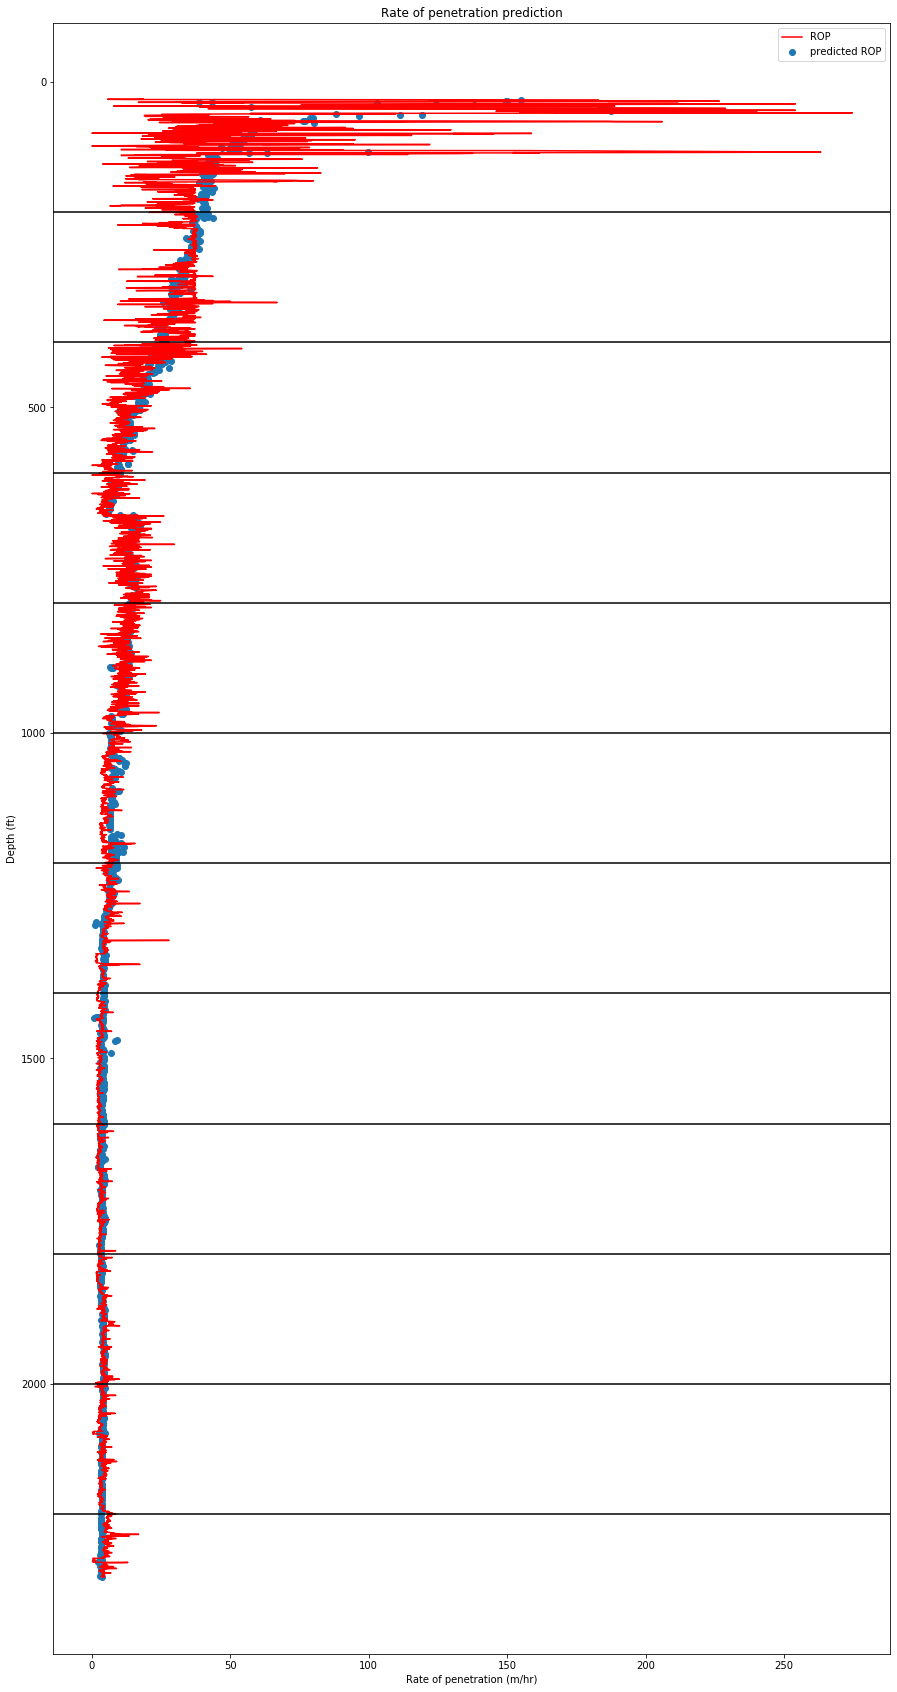

In [32]:
fig,ax=plt.subplots(figsize=(15,30))
ax.plot(y,X['Depth(m)'].values.reshape(-1,1),'r',label='ROP')
ax.scatter(predictions,X_test['Depth(m)'].values.reshape(-1,1),label='predicted ROP')
ay=plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)')
plt.xlabel('Rate of penetration (m/hr)')
plt.title('Rate of penetration prediction');
plt.legend(loc="best")
depth=[depth for depth in range(200,2400,200) ]
for i in range(len(depth)):
    plt.axhline(depth[i],color='black' )
    